# Hierarchical Image Matting of Blood Vessels in Fundus Images

This is the python implementation of this paper : **[A Hierarchical Image Matting Model for Blood Vessel Segmentation in Fundus images](https://arxiv.org/abs/1701.00892)**

## Modules of the code:

1. Vessel enhancement filters - Morphologically Recontructed Filter and Isotropic Undecimated Wavelet Filter
2. Image Segmentation
3. Vessel Skeleton Extraction
4. Trimap Generation
5. Hierarchical Image Matting Algorithm
6. Postprocessing

## Importing Libraries

In [30]:
!pip install tqdm

You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [31]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import sklearn
from skimage.exposure import rescale_intensity
from scipy import ndimage as nd
from skimage.morphology import label, remove_small_objects
from skimage.measure import regionprops, find_contours
from skimage.filters import threshold_otsu
from tqdm import tqdm

In [2]:
# os.listdir('DRIVE dataset/training/images')
os.chdir(os.path.join(os.getcwd(), 'DRIVE dataset/training/images'))
os.listdir()

['21_training.tif',
 '22_training.tif',
 '23_training.tif',
 '24_training.tif',
 '25_training.tif',
 '26_training.tif',
 '27_training.tif',
 '28_training.tif',
 '29_training.tif',
 '30_training.tif',
 '31_training.tif',
 '32_training.tif',
 '33_training.tif',
 '34_training.tif',
 '35_training.tif',
 '36_training.tif',
 '37_training.tif',
 '38_training.tif',
 '39_training.tif',
 '40_training.tif']

In [3]:
def extract_green_channel(file):
    img = cv2.imread(file)
    gr = np.zeros_like(img)
    gr = img[:,:,1]
    return gr

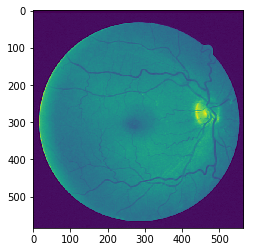

In [4]:
grChannel = extract_green_channel('22_training.tif')
plt.imshow(grChannel)

## 1) Vessel Enhancement Filters

### 1a) Morphologically Reconstructed Filter

The filter is defined as follows: $$I^\theta_{th}=I^c_g-(I^c_g \circ S^\theta_e)$$
where<br> 
$I^\theta_{th}$ is the top-hat transformed image <br> $I^c_g$ is the complement image <br> $S^\theta_e$ is the structuring element
<br> The structuring element used in this case is 21 px wide which is the approximate diameter of the biggest vessel in the image.<br>
The final result for the filter is given by: $$I_{mr}=\Sigma_{\theta \in A}I^\theta_{th}$$
where A = { x | 0 < x < $\pi$ & x mod ($\frac{\pi}{12}$) }




In [5]:
def rotate_image(mat, angle):
    height, width = mat.shape[:2]
    image_center = (width / 2, height / 2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1)

    radians = math.radians(angle)
    sin = math.sin(radians)
    cos = math.cos(radians)
    bound_w = int((height * abs(sin)) + (width * abs(cos)))
    bound_h = int((height * abs(cos)) + (width * abs(sin)))

    rotation_mat[0, 2] += ((bound_w / 2) - image_center[0])
    rotation_mat[1, 2] += ((bound_h / 2) - image_center[1])

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat 

In [6]:
kernel = np.ones((1,21), dtype = np.uint8)
print(rotate_image(kernel, 135).shape)

(15, 15)


In [7]:
def morph_recon_filter(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gr = clahe.apply(image)
    gr = ~gr
    kernel = np.zeros((21,21), dtype = np.uint8)
    kernel[10,:] = np.ones((1,21), dtype = np.uint8)
    morph_image = np.zeros_like(grChannel)
    for angle in range(15, 180, 180 // 12):
        image = cv2.morphologyEx(gr, cv2.MORPH_OPEN, rotate_image(kernel, angle), iterations = 1)
        morph_image = cv2.add(morph_image, cv2.subtract(gr, image))
    return morph_image

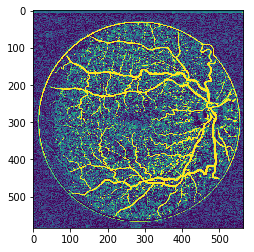

In [8]:
plt.imshow(morph_recon_filter(grChannel))

### 1b) Isotropic Undecimated Wavelet Filter

The filter is defined using the following equations:
$$c_{j+1}=c_j*h^{\uparrow j}$$
where $h_0$=[1,4,6,4,1]/16 which is upsampled by $2^j - 1$<br>
$$w_{j+1}=c_j-c_{j+1}$$
where $w_j$ represents the wavelet coefficient<br>$c_j$ represents the image convoluted<br>
$$I_{iuw}=c_n+\Sigma_{j=1}^nw_j$$
where $I_{iuw}$ represents the filter result

In [9]:
def convolve2D(image,kernel):
    (iH, iW) = image.shape
    (kH, kW) = kernel.shape
    pad = (kW - 1) // 2
    img = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    w = np.zeros((iH,iW), dtype = "float32")
    output = np.zeros((iH, iW), dtype = "float32")
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            roi = img[y - pad:y + pad + 1, x - pad:x + pad + 1]
            output[y - pad,x - pad] = (roi * kernel).sum()
    w = image - output
    output = rescale_intensity(output, in_range = (0,255))
    output = (output * 255).astype("uint8")
    return output, w

In [10]:
def isotropic_undec_wavelet_filter2D(image):
    # Bi-spline cubic function is given by h
    c_prv = image
    C1 = 1. / 16.
    C2 = 4. / 16.
    C3 = 6. / 16.
    W = []
    kernel_sizes = [5,9,17]
    for idx, ks in enumerate(kernel_sizes):
        ks = ks//2
        kernel = np.zeros((1, kernel_sizes[idx]), dtype = 'float32')
        kernel[0][0] = C1
        kernel[0][kernel_sizes[idx]-1] = C1
        kernel[0][int(ks/2)] = C2
        kernel[0][int(kernel_sizes[idx]/4+ks)] = C2
        kernel[0][ks] = C3
        c_nxt, w = convolve2D(c_prv, kernel.T * kernel)
        c_prv = c_nxt
        W.append(w)

    #     Computing the result Iiuw
    Iiuw = W[1] + W[2]
    return Iiuw, c_nxt, W
    

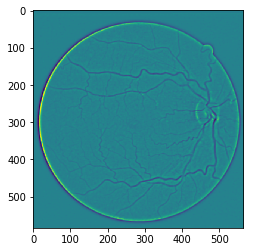

In [11]:
filtered_result, _, _ = isotropic_undec_wavelet_filter2D(grChannel)
plt.imshow(filtered_result)

## 2) Image Segmentation

This step involves the seperation of image into three regions namely **Background(B), Foreground(V1) and Unknown(U)**
<br>The image is split into theses three categories using the following conditions:
$$I_{mr}=\Bigg\{ B \ if \ 0<I_{mr}<p_1 \\ U \ if \ p_1\leq I_{mr}<p_2 \\ V_1 \ if \ p_2\leq I_{mr}$$
where $p_1$ = 0.2 and $p_2$ = 0.35 <br>
For removing noise, Area > $a_1$ whose Extent $\leq$ $e_1$ and VRatio $\leq$ r<br>

**Ranges:**<br> $e_1\in [0.2,0.4]$<br> $e_2\in [0.15,0.3]$<br> $r\in [2,6]$<br>$s\in [0.4,0.6]$

In [12]:
def contourProps(cnt):
    x, y, w, h = cv2.boundingRect(cnt)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(cnt)
    aspect_ratio = float(w) / h
    extent = cv2.contourArea(cnt) / float(w * h)
    solidity = float(cv2.contourArea(cnt)) / hull_area
    return aspect_ratio, extent, solidity

In [13]:
def image_segmentation(image):
    Imr = morph_recon_filter(image)
    # Imr = cv2.morphologyEx(Imr, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    Imr = Imr / max(np.ravel(Imr))
    B = (Imr < 0.42)
    U = (Imr > 0.42) * (Imr < 0.75)
    V1 = (Imr > 0.75) * 255
    # img = cv2.cvtColor(V1.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    _, contours, hierarchy = cv2.findContours(V1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    V2 = np.zeros(V1.shape, dtype = np.uint8)
    a1 = 2 * 21* max(V1.shape) / min(V1.shape)
    for cnt in contours:
        if cv2.contourArea(cnt) > a1:
            VRatio, extent, _ = contourProps(cnt)
            if extent <= 0.35 and VRatio <= 2.2:
                cv2.fillPoly(V2, pts = [cnt], color = [255,255,255])
    V2 = V1 * V2
    return B, U, V2
# label_img = label(V1, connectivity=2)
# props = regionprops(label_img)
# V2 = remove_small_objects(label_img, min_size=a1)
# cv2.imwrite('21_V2.png', V1)

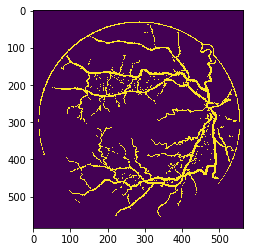

In [14]:
_, _, V2 = image_segmentation(grChannel)
plt.imshow(V2)

## 3) Vessel Skeleton Extraction

In this step we make use of the result from **Isotropic Undecimated Wavelet Filter** $I_{iuw}$<br>
Thresholding is done on the image using the following conditions:
$$T = 1 \ I_{iuw}>t\\ 0 \ I_{iuw}\leq t$$
where t = Otsu($I_{iuw}$) - $\epsilon$[0.03]

Further divided into three regions $T_1,T_2 \ \& \ T_3$
$$T_1 \ if \ 0<Area<a_1\\ T_2 \ if \ a_1\leq Area \geq a_2\\ T_3 \ if \ a_2<Area$$
where $a_1 = f_i \times 2$ and $a_2 = f_i \times 35$<br>$f_i = d \times \frac{max(h,w)}{min(h,w)}$

Further filtering is done on $T_2$ for inclusion into $T_3$, i.e., the vessel region. This is done by considering the Extent > $e_2$ and VRatio $\leq$ r.

In [15]:
def vessel_skeleton_extraction(image):
    Iiuw, _, _  = isotropic_undec_wavelet_filter2D(image)
    per_px_inc = 0.18
    epsilon = 0.03
    mask = cv2.imread('G:/Image processing projects/Fundus Blood Vessels Extraction/DRIVE dataset/training/mask/frame1.png', 0)
    t = np.sort(np.ravel(Iiuw))
    thres = t[int(per_px_inc * len(t)) - 1] + epsilon
    a2 = 35 * 21 * max(Iiuw.shape) / min(Iiuw.shape)
    a1 = 2 * 21 * max(Iiuw.shape) / min(Iiuw.shape)
    bw = Iiuw < thres
    bw = bw.astype(np.uint8) * 255
    fil_bw = cv2.bitwise_and(bw,bw, mask = mask)
    m = np.ones_like(mask) * 255
    m1 = np.ones_like(mask) * 255
    _, contours, _ = cv2.findContours(fil_bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if(area < a2):
            if(area < a1):
                cv2.drawContours(m1,[cnt],-1,0,-1)
            else:
                VRatio, extent, _ = contourProps(cnt)
                if((VRatio >= 2.2)and(extent < 0.25)):
                    cv2.drawContours(m1,[cnt],-1,0,-1)
            cv2.drawContours(m,[cnt],-1,0,-1)
    T3 = cv2.bitwise_and(fil_bw, m, mask = mask) 
    vse = cv2.bitwise_and(fil_bw, m1, mask = mask)
    return vse
# epsilon = 0.6
# thres_val = threshold_otsu(Iiuw, nbins = 325)
# thres_set = thres_val - epsilon
# pixels = np.sort(np.ravel(Iiuw))
# thres_set = pixels[int(len(pixels) * 0.22)]
# T = (Iiuw < thres_set) * 255
# _, contours, hirarchy = cv2.findContours(T, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

# T1 = np.ones(Iiuw.shape, dtype = np.uint8)
# T3 = np.ones(Iiuw.shape, dtype = np.uint8)
# T4 = np.ones(Iiuw.shape, dtype = np.uint8)
# for cnt in contours:
#     if cv2.contourArea(cnt) > a1:
#         if cv2.contourArea(cnt) < a2:
#             VRatio, extent, solidity = contourProps(cnt)
#             if extent > 0.25 and VRatio <= 2.2:
#                 cv2.drawContours(T4,[cnt],-1,0,-1)
#         else:
#             cv2.drawContours(T3,[cnt],-1,0,-1)
#     else:
#         cv2.drawContours(T1,[cnt],-1,0,-1)
# S = cv2.add(T3, T4)
# plt.imshow(T3)
            
        

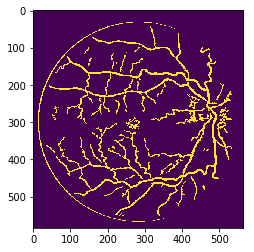

In [16]:
plt.imshow(vessel_skeleton_extraction(grChannel))

## 4) Trimap Generation

Generate the trimap by mixing the results of **Image Segmentation and Vessel Skeleton Extraction**

In [17]:
def trimap_formation(image):
    B, U, V2 = image_segmentation(image)
    S = vessel_skeleton_extraction(image)
    V2 = V2.astype(np.uint8)
    mask = cv2.imread('G:/Image processing projects/Fundus Blood Vessels Extraction/DRIVE dataset/training/mask/frame1.png', 0)
    B = cv2.bitwise_and((B * 255).astype(np.uint8),(B * 255).astype(np.uint8), mask=mask)
    V = cv2.bitwise_or(V2, S, mask = mask)
    V = cv2.bitwise_and(V, V, mask = ~B)
    U = (U * 127).astype(np.uint8)
    U = cv2.bitwise_and(U, U, mask = mask)
    return V, U, B

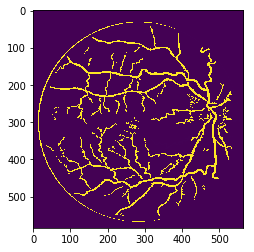

In [42]:
V1, U, _ = trimap_formation(grChannel)
plt.imshow(V1)
# plt.imshow(U)

## 5) Hierarchical Image Matting Algorithm

The basic idea of this algorithm is successfully labelling the unknown pixels as either **Background** or **Vessel Region**.
This is given as the equation of the form: 
$$I_v(z)= \ 1 \ if \ corre(u^j_i,V)>corre(u^j_i,B)\\ 0 \ else$$

The image matting algorithm can be broken down to two parts:
1. Stratifiying unknown pixels
2. Hierarchical Update

### 5a)Stratifying Unknown Pixels

The following steps are followed for arranging the pixels into layers:
1. Find the distance of each unknown pixel from the nearest vessel pixel(d)
2. Arrange in ascending order
3. Cluster the pixels into hierarchies with common distance d

In [19]:
unk = U == 127
np.sum(unk)

50909

In [25]:
def stratify_unknown(image):
    V, U, _ = trimap_formation(image)
    dist_ves = cv2.distanceTransform(~V, cv2.DIST_L2, 3)
    unk = U == 127
    d = dist_ves * unk
    d_r = np.sort(np.ravel(d))
    hierarchy = []
    for i, dist in enumerate(np.unique(d_r)):
        if dist == 0:
            continue
        l = [i, dist]
        a = d == dist
        pts = []
        for i in range(d.shape[0]):
            for j in range(d.shape[1]):
                if a[i,j]:
                    pts.append(np.array([i, j]))
        l.append(pts)
        hierarchy.append(l)
    return hierarchy
            
    

In [26]:
hierarchy = stratify_unknown(grChannel)
def generators():
    for i in hierarchy:
        yield i[0]
print(np.array(list(map(int, generators()))))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

### 5b) Hierarchical Update

Iterate over the clusters formed one by one and find their correlation value using the formula:
$$\beta(u^j_i,k^j_i)=\beta_c(u^j_i,k^j_i)+\omega\beta_s(u^j_i,k^j_i) \\ \beta_c(u^j_i,k^j_i)=\|c_{u^j_i}-c_{k^j_i}\| \\ \beta_s(u^j_i,k^j_i)=\frac{\|x_{u^j_i}-x_{k^j_i}\|-x_{min}}{x_{max}-x_{min}}$$
where 
>**c** represents the intensity level<br>
**$\beta$** is the correlation function (contrast and spatial)<br>
**$\omega$** is the weight tradeoff fixed at 0.5 for this problem


In [49]:
# hierarchy = stratify_unknown(grChannel)
V, U, B = trimap_formation(grChannel)
V1 = np.zeros_like(V)
# mask = cv2.imread('G:/Image processing projects/Fundus Blood Vessels Extraction/DRIVE dataset/training/mask/frame1.png', 0)
# B = cv2.bitwise_or(B, ~mask)
# plt.imshow(B)
# Imr = morph_recon_filter(grChannel) 
# Imr = Imr / np.max(Imr)
# kernel_size = 9
# main_dist_kernel = np.zeros(shape=(kernel_size, kernel_size), dtype = np.uint8)
# main_dist_kernel[4,4] = 255
# main_dist_kernel = cv2.distanceTransform(~main_dist_kernel, cv2.DIST_L2, 3)
for cluster in tqdm(hierarchy):
    for pts in cluster[2]:
        if pts[0] - kernel_size // 2 < 0 or pts[0] + kernel_size // 2 + 1 > V.shape[0] or pts[1] - kernel_size // 2 < 0 or pts[1] + kernel_size // 2 + 1 > V.shape[1]:
            continue
        kernel_V = V[pts[0] - kernel_size // 2:pts[0] + kernel_size // 2 + 1, pts[1] - kernel_size // 2:pts[1] + kernel_size // 2 + 1]
        kernel_B = B[pts[0] - kernel_size // 2:pts[0] + kernel_size // 2 + 1, pts[1] - kernel_size // 2:pts[1] + kernel_size // 2 + 1]
        dist_V = main_dist_kernel * kernel_V.astype(np.bool)
        dist_B = main_dist_kernel * kernel_V.astype(np.bool)
        beta_V = []
        beta_B = []
        # Imr = morph_recon_filter(grChannel) / np.max(Imr)
        # normalized_Imr = np.
        l = np.unique(np.sort(np.ravel(dist_V)))
        lB = np.unique(np.sort(np.ravel(dist_V)))
        omega = 0.5
        for i in range(dist_V.shape[0]):
            for j in range(dist_V.shape[1]):
                if dist_V[i,j]:
                    beta_c = abs(Imr[pts[0],pts[1]] - Imr[pts[0] - kernel_size // 2 + i, pts[1] - kernel_size // 2 + j])
                    beta_s = float(dist_V[i,j] - l[1]) / l[-1]
                    beta_V.append(beta_c + omega * beta_s)
                if dist_B[i,j]:
                    beta_c = abs(Imr[pts[0],pts[1]] - Imr[pts[0] - kernel_size // 2 + i, pts[1] - kernel_size // 2 + j])
                    beta_s = float(dist_V[i,j] - lB[1]) / lB[-1]
                    beta_B.append(beta_c + omega * beta_s)
        if len(beta_V) == 0 or len(beta_B) == 0:
            if len(beta_V):
                V1[pts[0], pts[1]] = 255
            else:
                B[pts[0], pts[1]] = 255
            continue
        if np.linalg.norm(np.array(beta_V)) > np.linalg.norm(np.array(beta_B)):
            V1[pts[0], pts[1]] = 255
        else:
            B[pts[0], pts[1]] = 255
#         print(kernel.shape)
#         break
#     break

100%|████████████████████████████████████████████████████████████████████████████████| 775/775 [00:12<00:00, 60.84it/s]


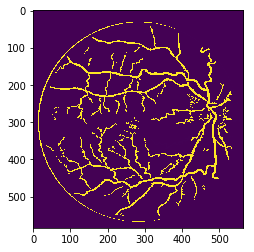

In [41]:
plt.imshow(V)
    
    

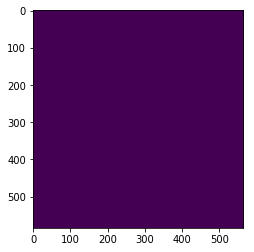

In [50]:
plt.imshow(V1)

In [44]:
# dist_V = main_dist_kernel * kernel_V.astype(np.bool)
# dist_B = main_dist_kernel * kernel_B.astype(np.bool)
beta_V = []
beta_B = []
# Imr = morph_recon_filter(grChannel) / np.max(Imr)
# normalized_Imr = np.
l = np.unique(np.sort(np.ravel(dist_V)))
lB = np.unique(np.sort(np.ravel(dist_V)))
min_value = l[1]
max_value = l[-1]
omega = 0.5
for i in range(dist_V.shape[0]):
    for j in range(dist_V.shape[1]):
        if dist_V[i,j]:
            beta_c = abs(Imr[pts[0],pts[1]] - Imr[pts[0] - kernel_size // 2 + i, pts[0] - kernel_size // 2 + j])
            beta_s = float(dist_V[i,j] - min_value) / max_value
            beta_V.append(beta_c + omega * beta_s)
        if dist_B[i,j]:
            beta_c = abs(Imr[pts[0],pts[1]] - Imr[pts[0] - kernel_size // 2 + i, pts[0] - kernel_size // 2 + j])
            beta_s = float(dist_V[i,j] - lB[1]) / lB[-1]
            beta_B.append(beta_c + omega * beta_s)
        
print(beta_V, beta_B)
        
# dist_B

[0.6913985592840044, 0.6239735635121175, 0.6389015345608278, 0.5825750298722396, 0.5497779177152625, 0.6061044416369457, 0.6624309463255337, 0.7651500597444794, 0.8443397357545926, 0.7997779369483575, 0.6970588235294117, 0.5825750298722396, 0.4798559228643256, 0.4470588235294118, 0.5151500405113845, 0.6061044416369457, 0.7088235294117647, 0.9056602898895341, 0.7787455242627017, 0.6642617306055296, 0.5733073294799684, 0.4470588235294118] [0.12081031757885514, 0.25022208228473747, 0.2384573764023845, 0.32081031757885514, 0.4502220822847375, 0.4502220822847375, 0.4502220822847375, 0.4502220822847375, 0.33257502346120804, 0.21492796463767866, 0.2384573764023845, 0.4502220822847375, 0.4502220822847375, 0.21492796463767866, 0.2031632587553257, 0.33257502346120804, 0.32081031757885514, 0.35610443522591395, 0.33257502346120804, 0.2031632587553257, 0.21492796463767866, 0.35610443522591395, 0.20708482738277667, 0.2031632587553257, 0.35610443522591395, 0.4502220822847375, 0.4502220822847375, 0.34

In [46]:
np.max(np.array(beta_c)) - np.max(np.array(beta_B))

-0.2580652195396394

## 6) Postprocessing

This step serves as the final denoiser to eliminate the non-vessel regions that have been included: Extent > $e_2$, Area < $a_2$ and VRatio < r.

[775, 43.494606, [array([341, 362])]]